In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from sklearn.preprocessing import minmax_scale

In [32]:
query_df = pd.read_csv('Test_Data/query_dataset.csv')
reference_df = pd.read_csv('Test_Data/reference_dataset.csv')

In [33]:
wavenumbers = query_df.columns[:-1]
query_intensities = query_df[wavenumbers].values
reference_intensities = reference_df[wavenumbers].values

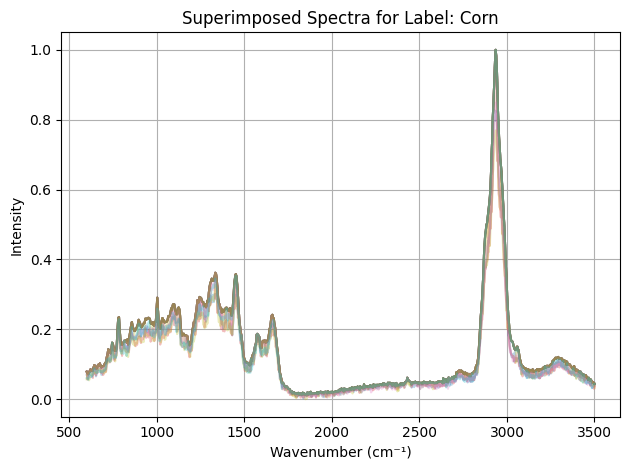

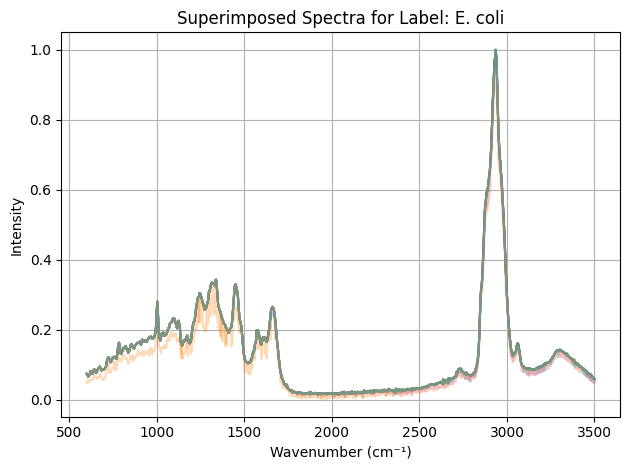

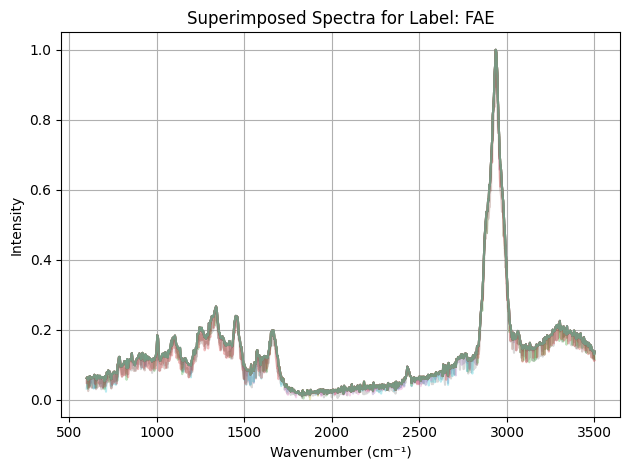

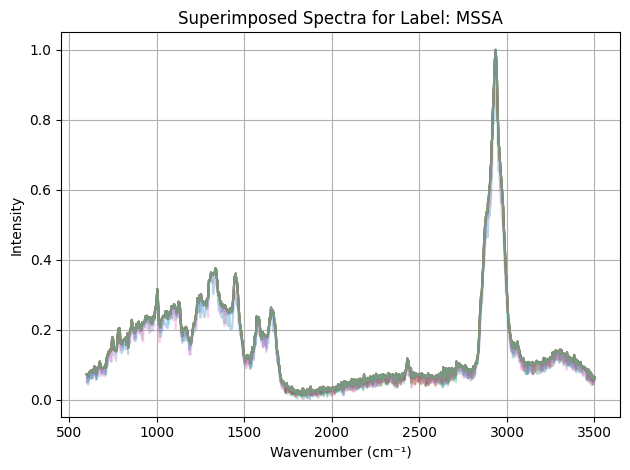

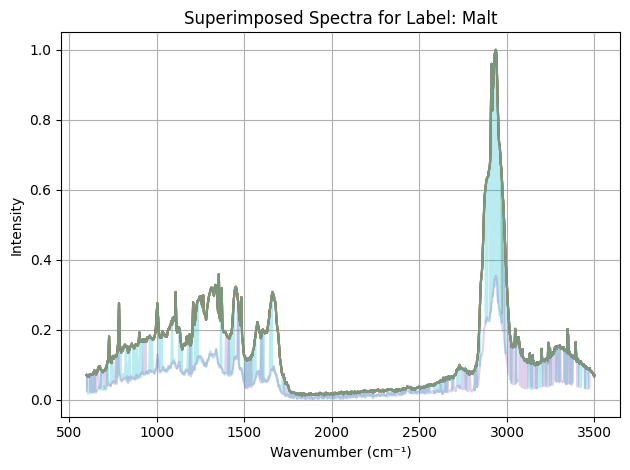

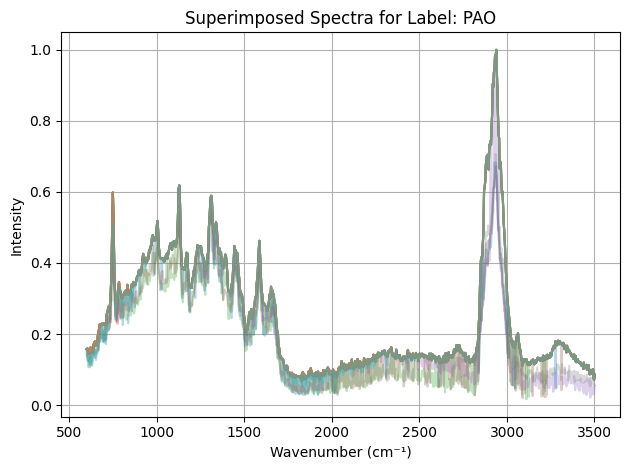

In [34]:

# Extract labels from the reference dataset
reference_labels = reference_df.iloc[:, -1]
unique_labels = reference_labels.unique()

# Plot each label with all spectra superimposed
for label in unique_labels:
    plt.figure()
    spectra = reference_df[reference_df.iloc[:, -1] == label]
    for i in range(spectra.shape[0]):
        plt.plot(wavenumbers.astype(float), spectra.iloc[i, :-1], alpha=0.3)
    plt.title(f'Superimposed Spectra for Label: {label}')
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [35]:
def baseline_als(y,lam = 1e6,p = 0.01,niter = 5):
    L = len(y)
    D = np.diff(np.eye(L),2)
    D = lam * (D @ D.T)
    w = np.ones(L)
    for _ in range(niter):
        W = np.diag(w)
        Z = W + D
        baseline = np.linalg.solve(Z,w * y)

        w = p* (y > baseline) + (1-p) * (y < baseline)
    return baseline

def preprocess(spectra):
    out = np.zeros_like(spectra)
    for i, spec in enumerate(spectra):
        bkg  = baseline_als(spec)
        spec_corr = spec - bkg
        norm = np.linalg.norm(spec_corr)
        out[i] = spec_corr / norm if norm != 0 else spec_corr
    return out

In [36]:
query_corrected = preprocess(query_intensities)
reference_corrected = preprocess(reference_intensities)

In [37]:
query_proc_df = pd.DataFrame(query_corrected, columns=wavenumbers)
query_proc_df['Species'] = query_df['Species']

reference_proc_df = pd.DataFrame(reference_corrected, columns=wavenumbers)
reference_proc_df['Species'] = reference_df['Species']

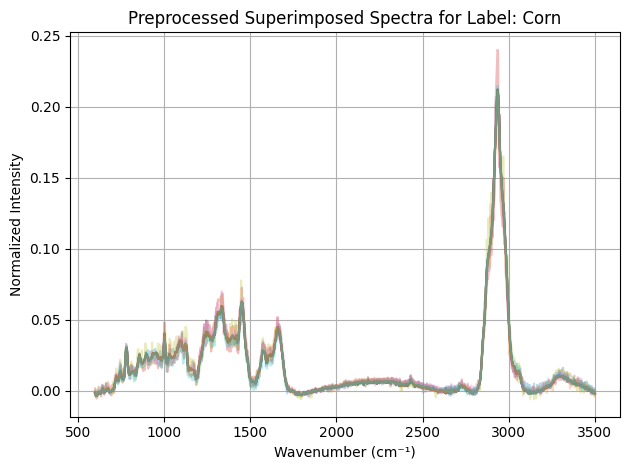

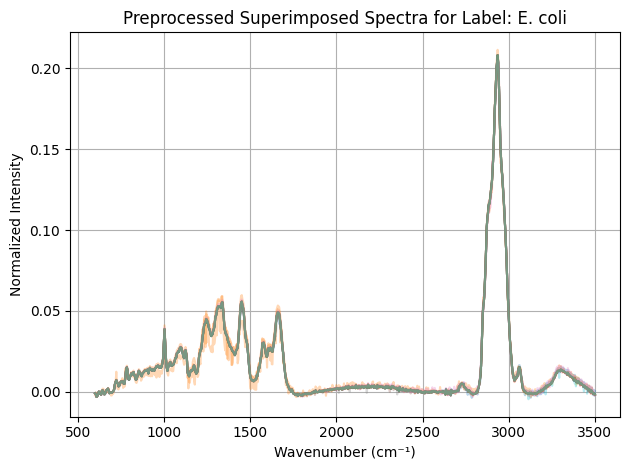

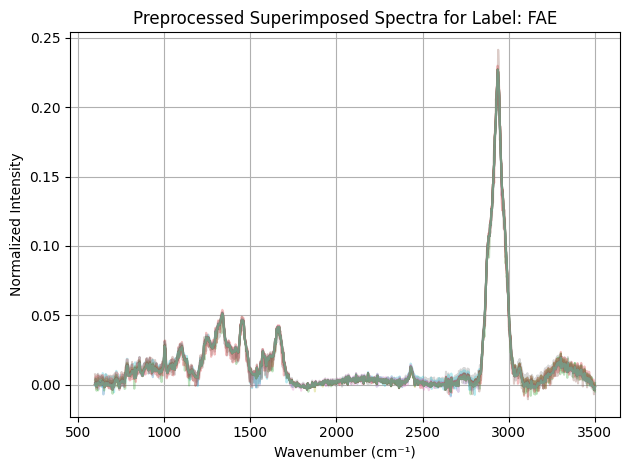

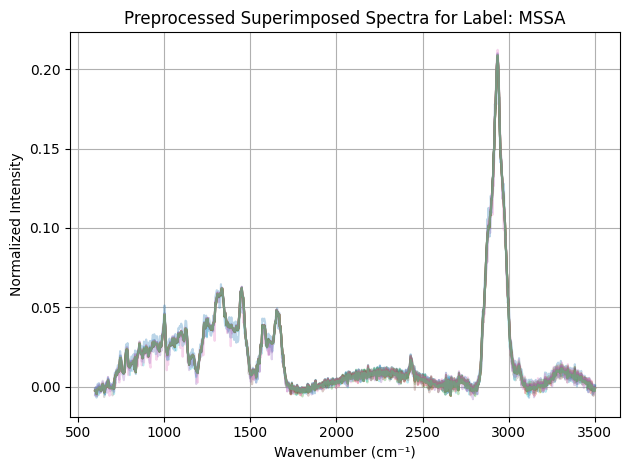

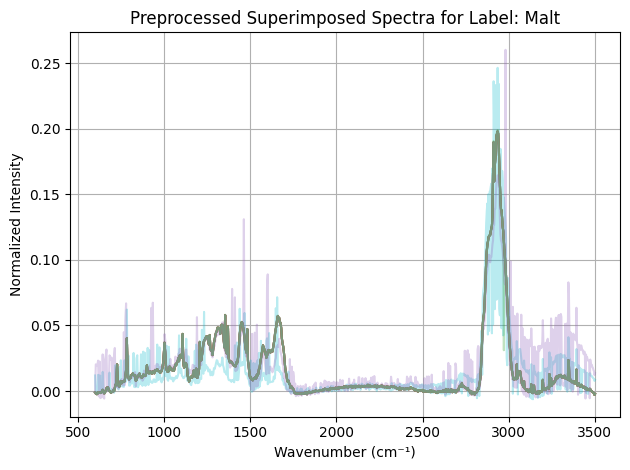

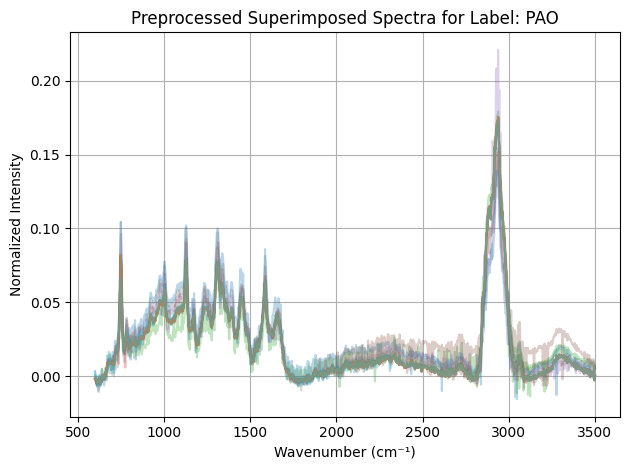

In [38]:
unique_labels = reference_proc_df['Species'].unique()

for label in unique_labels:
    plt.figure()
    spectra = reference_proc_df[reference_proc_df['Species'] == label]
    for i in range(spectra.shape[0]):
        plt.plot(wavenumbers.astype(float), spectra.iloc[i, :-1], alpha=0.3)
    plt.title(f'Preprocessed Superimposed Spectra for Label: {label}')
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Normalized Intensity')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [39]:
raw_query = pd.read_csv('Test_Data/query_dataset.csv')
raw_ref = pd.read_csv('Test_Data/reference_dataset.csv')
wavs = raw_query.columns[:-1]

def baseline_als(y, lam=1e4, p=0.01, niter=10):
    L = len(y); D = np.diff(np.eye(L), 2); D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        W = np.diag(w); Z = W + D
        baseline = np.linalg.solve(Z, w*y)
        w = p * (y > baseline) + (1-p) * (y < baseline)
    return baseline

def preprocess(intensities):
    out = np.zeros_like(intensities)
    for i, spec in enumerate(intensities):
        bkg = baseline_als(spec)
        corr = spec - bkg
        nrm = np.linalg.norm(corr)
        out[i] = corr/nrm if nrm!=0 else corr
    return out


Q = preprocess(raw_query[wavs].values)
R = preprocess(raw_ref[wavs].values)
dfQ = pd.DataFrame(Q, columns=wavs); dfQ['Species'] = raw_query['Species']
dfR = pd.DataFrame(R, columns=wavs); dfR['Species'] = raw_ref['Species']

In [40]:
K_smooth, N_peak, w_max = 3,10,50
def smooth_spectrum(spec): return np.convolve(spec,np.ones(K_smooth)/K_smooth,mode='same')

def CaPE(refs):
    sm = np.array([smooth_spectrum(s) for s in refs])
    counts = np.zeros(sm.shape[1], int)
    for s in sm:
        pks, _ = find_peaks(s, height=0.025)
        counts[pks] += 1
    return sorted(np.argsort(counts)[-N_peak:])

def CaPE_peak_intensity(refs):
    sm = np.array([smooth_spectrum(s) for s in refs])
    peak_intensity = np.zeros(sm.shape[1])
    for s in sm:
        peaks, _ = find_peaks(s)
        peak_intensity[peaks] += s[peaks]
    cp_idxs = sorted(np.argsort(peak_intensity)[-N_peak:])
    return cp_idxs

def extract_vec(spec, cp_idxs):
    hw = w_max//2
    vec = [spec[max(0,i-hw):min(len(spec),i+hw+1)].max() for i in cp_idxs]
    return minmax_scale(vec)

In [41]:
CPs = {}
compressed_ref = {}
for chem, grp in dfR.groupby('Species'):
    refs = grp[wavs].values
    cp_idxs = CaPE(refs)
    CPs[chem] = cp_idxs
    compressed_ref[chem] = np.array([extract_vec(s, cp_idxs) for s in refs])

In [42]:
def CaPSim(qv, rvs): return (rvs @ qv).mean()
def identify(spec):
    scores = {}
    for chem, cp in CPs.items():
        qv = extract_vec(spec, cp)
        scores[chem] = CaPSim(qv, compressed_ref[chem])
    best = max(scores, key=scores.get)
    return best, scores


In [43]:
top1_correct = 0
top2_correct = 0
total = len(dfQ)

for _, row in dfQ.iterrows():
    true_label = row['Species']
    
    # 1) Get the raw similarity scores dict, {chem: score}
    scores = identify(row[wavs].values)[1]
    
    # 2) Rank chemicals by score descending
    ranked_chems = sorted(scores, key=scores.get, reverse=True)
    
    # 3) Check top-1
    if true_label == ranked_chems[0]:
        top1_correct += 1
    
    # 4) Check top-2
    if true_label in ranked_chems[:2]:
        top2_correct += 1

# Compute accuracies
top1_accuracy = top1_correct / total
top2_accuracy = top2_correct / total

print(f"Top-1 accuracy over {total} queries: {top1_accuracy:.2%}")
print(f"Top-2 accuracy over {total} queries: {top2_accuracy:.2%}")


Top-1 accuracy over 60 queries: 16.67%
Top-2 accuracy over 60 queries: 33.33%


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# 1) Load raw reference data
raw_ref = pd.read_csv('Test_Data/reference_dataset.csv')
wavs_str = raw_ref.columns[:-1]
wavs = wavs_str.astype(float)

# 2) Baseline removal (AsLS) and ℓ₂ normalization 
# Fine-tuning AsLS
def baseline_als(y, lam=1e4, p=0.01, niter=10):
    L = len(y)
    D = np.diff(np.eye(L), 2); D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        W = np.diag(w); Z = W + D
        b = np.linalg.solve(Z, w * y)
        w = p * (y > b) + (1-p) * (y < b)
    return b

def preprocess(spectra):
    out = np.zeros_like(spectra)
    for i, spec in enumerate(spectra):
        bkg  = baseline_als(spec)
        corr = spec - bkg
        nrm  = np.linalg.norm(corr)
        out[i] = corr / nrm if nrm else corr
    return out

# Apply to reference spectra
refs_raw = raw_ref[wavs_str].values.astype(float)
refs_proc = preprocess(refs_raw)


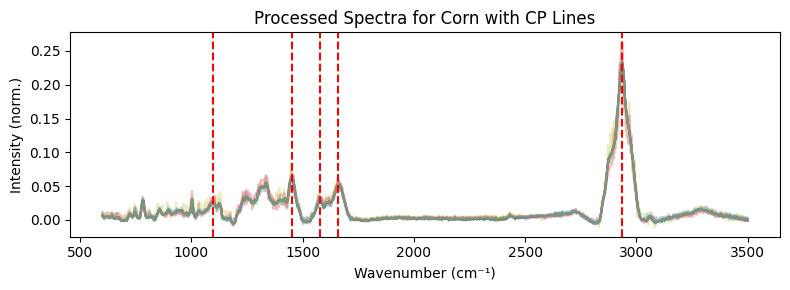

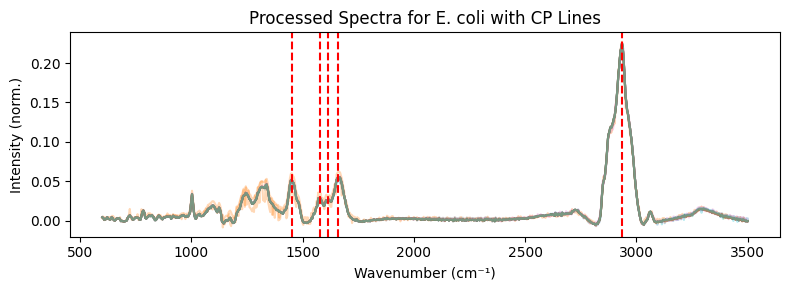

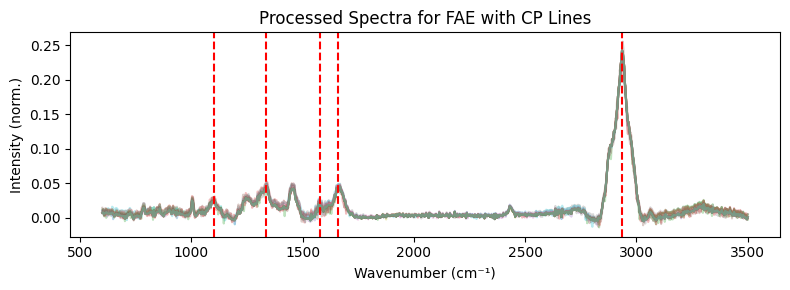

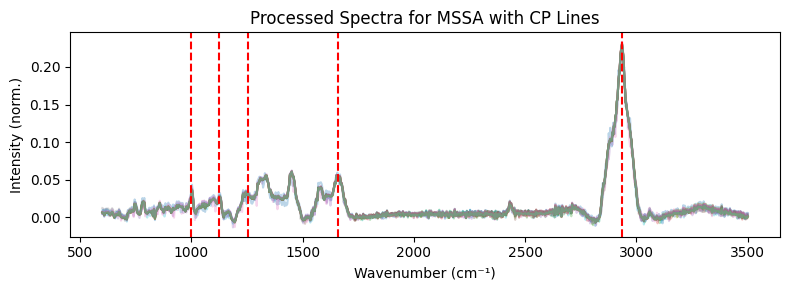

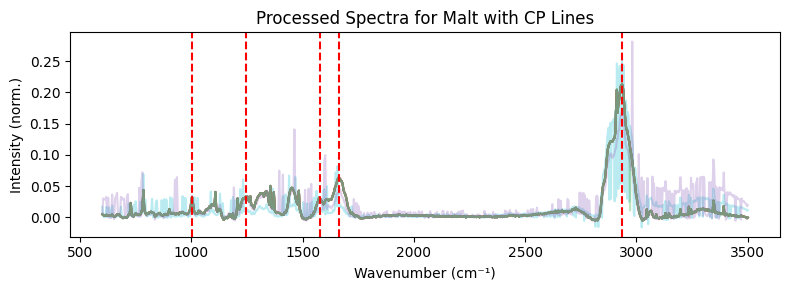

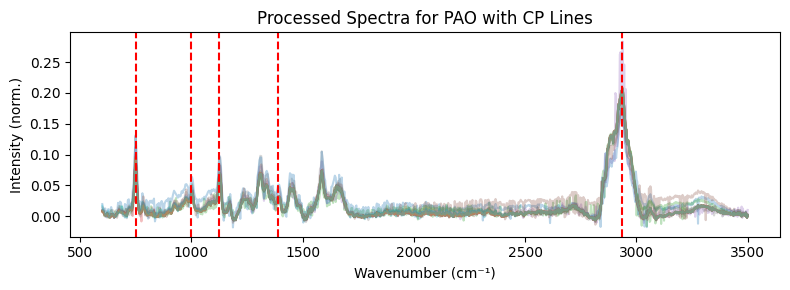

In [45]:
# 3) CaPE on processed data
K_smooth, N_peak = 5, 5

def smooth_spectrum(spec):
    return np.convolve(spec, np.ones(K_smooth)/K_smooth, mode='same')

def CaPE_peak_intensity(refs):
    sm = np.array([smooth_spectrum(s) for s in refs])
    peak_intensity = np.zeros(sm.shape[1])
    for s in sm:
        peaks, _ = find_peaks(s)
        peak_intensity[peaks] += s[peaks]
    cp_idxs = sorted(np.argsort(peak_intensity)[-N_peak:])
    return peak_intensity, cp_idxs

def CaPE(refs):
    sm = np.array([smooth_spectrum(s) for s in refs])
    counts = np.zeros(sm.shape[1], int)
    for s in sm:
        pks, _ = find_peaks(s, height=0.0175)  # Adjust height threshold as needed
        counts[pks] += 1
    return sorted(np.argsort(counts)[-N_peak:])

# 4) Plot for each species (processed)
for chem in sorted(raw_ref['Species'].unique()):
    group = raw_ref[raw_ref['Species']==chem]
    idxs  = group.index.to_list()
    refs_p = refs_proc[idxs]  # pick processed spectra for this species
    
    cp_idxs = CaPE(refs_p)
    cp_wavenums = wavs[cp_idxs]
    
  
    
    # Overlay processed spectra + CP lines
    plt.figure(figsize=(8,3))
    for spec in refs_p:
        plt.plot(wavs, spec, alpha=0.3)
    for w in cp_wavenums:
        plt.axvline(w, linestyle='--', color='red')
    plt.title(f"Processed Spectra for {chem} with CP Lines")
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Intensity (norm.)')
    plt.tight_layout()
    plt.show()

In [46]:
import pandas as pd
import numpy as np

# 1) Load raw data
raw_ref   = pd.read_csv('Test_Data/reference_dataset.csv')
wavs_all  = raw_ref.columns[:-1].astype(float)
mask      = (wavs_all >= 600) & (wavs_all <= 1700)  # keep only fingerprint

# 2) Subset your wavenumbers and raw arrays
wavs       = wavs_all[mask]
wavs_str   = raw_ref.columns[:-1][mask]
refs_raw   = raw_ref[wavs_str].values.astype(float)

# 3) Preprocess (baseline + ℓ₂ norm) on cropped data
def baseline_als(y, lam=1e4, p=0.0001, niter=7):
    L = len(y)
    D = np.diff(np.eye(L), 2); D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        W = np.diag(w); Z = W + D
        b = np.linalg.solve(Z, w * y)
        w = p * (y > b) + (1-p) * (y < b)
    return b

def preprocess(spectra):
    out = np.zeros_like(spectra)
    for i, spec in enumerate(spectra):
        bkg  = baseline_als(spec)
        corr = spec - bkg
        nrm  = np.linalg.norm(corr)
        out[i] = corr / nrm if nrm else corr
    return out

refs_proc = preprocess(refs_raw)


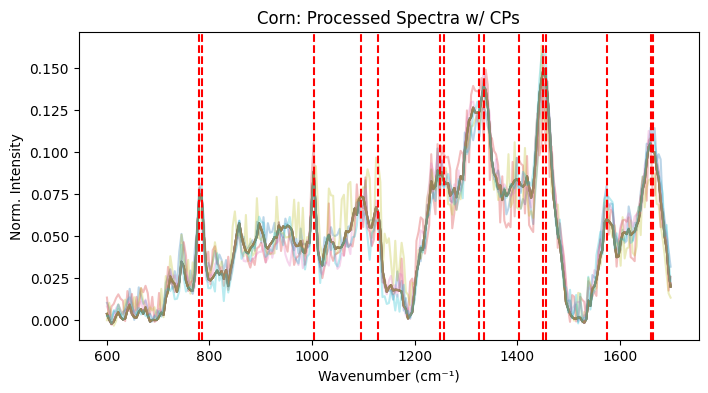

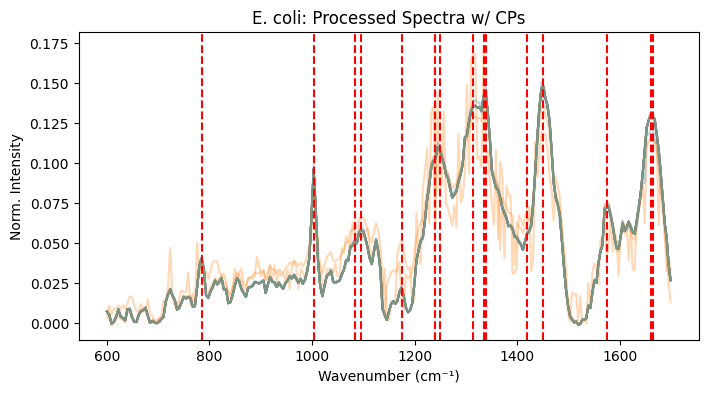

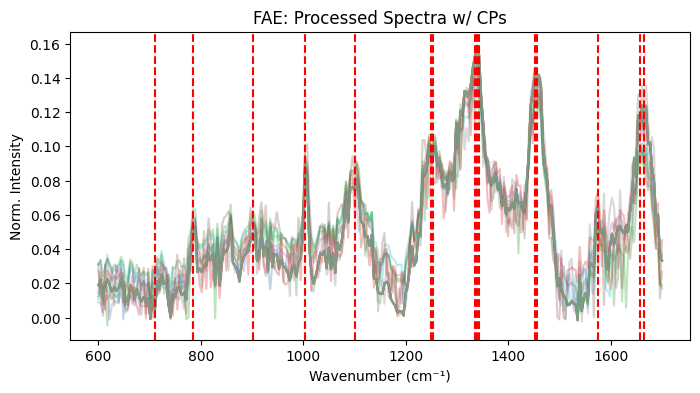

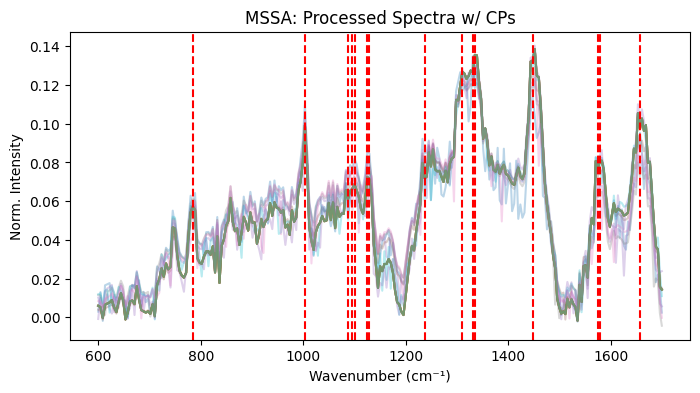

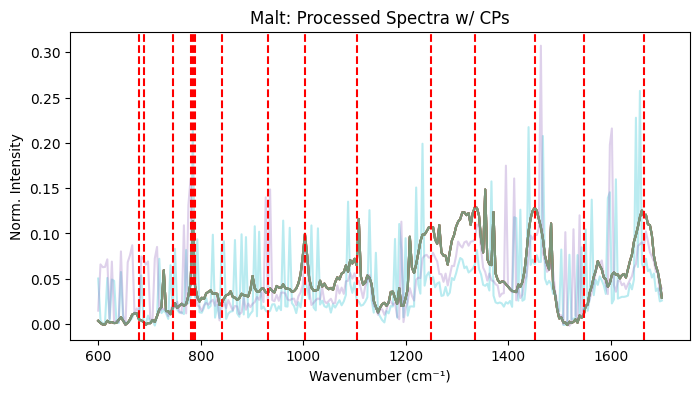

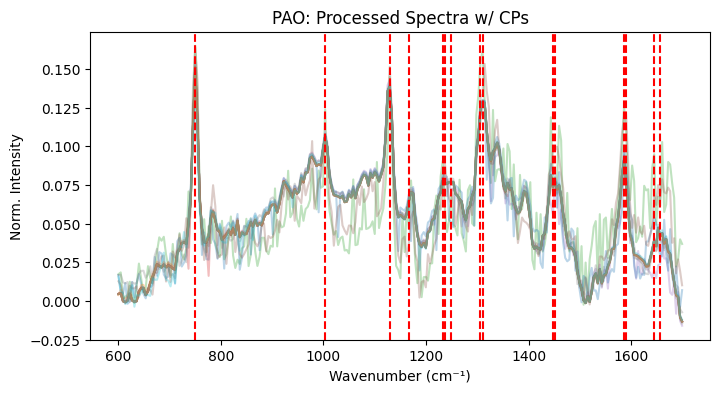

In [47]:
# 4) Run CaPE and plotting on refs_proc using only wavs and wavs_str
K_smooth, N_peak = 3, 15

def smooth_spectrum(spec):
    return np.convolve(spec, np.ones(K_smooth)/K_smooth, mode='same')

def CaPE(refs):
    sm = np.array([smooth_spectrum(s) for s in refs])
    counts = np.zeros(sm.shape[1], int)
    for s in sm:
        pks, _ = find_peaks(s, height=0.02,prominence=0.02,distance=1)  # Adjust height threshold as needed
        counts[pks] += 1
    return sorted(np.argsort(counts)[-N_peak:])

import matplotlib.pyplot as plt

for chem in sorted(raw_ref['Species'].unique()):
    idxs  = raw_ref.index[raw_ref['Species']==chem]
    refs_p = refs_proc[idxs]
    
    cp_idxs = CaPE(refs_p)
    cp_wavenums = wavs[cp_idxs]

    
    # Overlay spectra
    plt.figure(figsize=(8,4))
    for spec in refs_p:
        plt.plot(wavs, spec, alpha=0.3)
    for w in cp_wavenums:
        plt.axvline(w, linestyle='--', color='red')
    plt.title(f"{chem}: Processed Spectra w/ CPs")
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Norm. Intensity')
    plt.show()

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.preprocessing import minmax_scale

# 1) Load raw data
query_df = pd.read_csv('query_dataset.csv')
ref_df   = pd.read_csv('reference_dataset.csv')
wavs_all = query_df.columns[:-1].astype(float)

# 2) Crop to fingerprint region 600–1700 cm⁻¹
mask    = (wavs_all >= 600) & (wavs_all <= 1700)
wavs    = wavs_all[mask]
wavs_str= query_df.columns[:-1][mask]

# 3) Baseline removal (AsLS) and ℓ₂ normalization
def baseline_als(y, lam=1e4, p=0.0001, niter=7):
    L = len(y)
    D = np.diff(np.eye(L), 2)
    D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        W = np.diag(w)
        Z = W + D
        b = np.linalg.solve(Z, w * y)
        w = p * (y > b) + (1 - p) * (y < b)
    return b

def preprocess(arr):
    out = np.zeros_like(arr)
    for i, spec in enumerate(arr):
        bkg  = baseline_als(spec)
        corr = spec - bkg
        nrm  = np.linalg.norm(corr)
        out[i] = corr / nrm if nrm else corr
    return out

# Apply preprocess to both datasets
Q_raw = query_df[wavs_str].values.astype(float)
R_raw = ref_df[wavs_str].values.astype(float)
Q_proc = preprocess(Q_raw)
R_proc = preprocess(R_raw)

# Reattach species labels
dfQ = pd.DataFrame(Q_proc, columns=wavs_str); dfQ['Species'] = query_df['Species']
dfR = pd.DataFrame(R_proc, columns=wavs_str); dfR['Species'] = ref_df['Species']

# 4) CaPE parameters & intensity-based extraction
K_smooth, N_peak, w_max = 5, 14, 36

def smooth_spectrum(spec):
    return np.convolve(spec, np.ones(K_smooth)/K_smooth, mode='same')

def CaPE_peak_intensity(refs):
    sm = np.array([smooth_spectrum(s) for s in refs])
    peak_intensity = np.zeros(sm.shape[1])
    for s in sm:
        peaks, _ = find_peaks(s)
        peak_intensity[peaks] += s[peaks]
    cp_idxs = sorted(np.argsort(peak_intensity)[-N_peak:])
    return peak_intensity, cp_idxs

def extract_vec(spec, cp_idxs):
    hw = w_max // 2
    vals = [spec[max(0, i-hw):i+hw+1].max() for i in cp_idxs]
    return minmax_scale(vals)

# 5) Plot CPs for each species
for chem in sorted(dfR['Species'].unique()):
    grp = dfR[dfR['Species']==chem]
    specs = grp[wavs_str].values
    peak_intensity, cp_idxs = CaPE_peak_intensity(specs)
    cp_wavs = wavs[cp_idxs]
    
    # Histogram
    plt.figure(figsize=(8,3))
    plt.plot(wavs, peak_intensity, label='Summed Peak Intensity')
    plt.scatter(cp_wavs, peak_intensity[cp_idxs], color='red', marker='x', label='CPs')
    plt.title(f"{chem} CP-Intensity Histogram")
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Summed Intensity')
    plt.legend(); plt.tight_layout(); plt.show()
    
    # Overlay spectra
    plt.figure(figsize=(8,3))
    for s in specs:
        plt.plot(wavs, s, alpha=0.3)
    for w in cp_wavs:
        plt.axvline(x=w, linestyle='--', color='red')
    plt.title(f"{chem} Processed Spectra with CPs")
    plt.xlabel('Wavenumber (cm⁻¹)'); plt.ylabel('Intensity')
    plt.tight_layout(); plt.show()

# 6) Build CP dictionary and compressed reference library
CPs = {}
compressed_ref = {}
for chem, grp in dfR.groupby('Species'):
    specs = grp[wavs_str].values
    _, cp_idxs = CaPE_peak_intensity(specs)
    CPs[chem] = cp_idxs
    compressed_ref[chem] = np.array([extract_vec(s, cp_idxs) for s in specs])

# 7) CaPSim and identify function
def CaPSim(qv, ref_vs):
    return (ref_vs @ qv).mean()

def identify(spec):
    scores = {chem: CaPSim(extract_vec(spec, CPs[chem]), compressed_ref[chem])
              for chem in CPs}
    best = max(scores, key=scores.get)
    return best, scores

# 8) Evaluate top-1 and top-2 accuracy
top1 = top2 = 0
total = len(dfQ)
for _, row in dfQ.iterrows():
    true = row['Species']
    _, scores = identify(row[wavs_str].values)
    ranked = sorted(scores, key=scores.get, reverse=True)
    if true == ranked[0]: top1 += 1
    if true in ranked[:2]: top2 += 1

print(f"Top-1 accuracy: {top1/total:.2%}")
print(f"Top-2 accuracy: {top2/total:.2%}")


FileNotFoundError: [Errno 2] No such file or directory: 'query_dataset.csv'

In [ ]:
import pandas as pd
import numpy as np
import time

ref_df = pd.read_csv('reference_dataset.csv')
wavs_str = ref_df.columns[:-1]
refs_raw = ref_df[wavs_str].values.astype(float)

def baseline_als(y, lam, p, niter):
    L = len(y)
    D = np.diff(np.eye(L), 2); D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        W = np.diag(w); Z = W + D
        b = np.linalg.solve(Z, w * y)
        w = p * (y > b) + (1 - p) * (y < b)
    return b

def preprocess(spectra, lam, p, niter):
    out = np.zeros_like(spectra)
    for i, spec in enumerate(spectra):
        bkg = baseline_als(spec, lam, p, niter)
        corr = spec - bkg
        nrm = np.linalg.norm(corr)
        out[i] = corr / nrm if nrm else corr
    return out


# Time preprocess for first 10 spectra
lam, p, niter = 1e5, 0.01, 10
start = time.perf_counter()
_ = preprocess(refs_raw[:10], lam, p, niter)
end = time.perf_counter()
time_per_spec = (end - start) / 10

lam_vals = [1e3,1e4, 1e5, 1e6,1e7]
p_vals   = [0.0001,0.001, 0.01,0.05 ,0.1,0.2]
niter_vals = [5, 10, 20,30]

num_combinations = len(lam_vals) * len(p_vals) * len(niter_vals)
N = refs_raw.shape[0]

# Estimate total time
total_time_sec = N * time_per_spec * num_combinations

print(f"Reference spectra count: {N}")
print(f"Avg time per spectrum: {time_per_spec:.4f} s")
print(f"Param combos: {num_combinations}")
print(f"Estimated total time: {total_time_sec/60:.2f} minutes")

Reference spectra count: 120
Avg time per spectrum: 28.5002 s
Param combos: 120
Estimated total time: 6840.05 minutes


In [ ]:
import os 
import numpy as np
import matplotlib.pyplot as plt

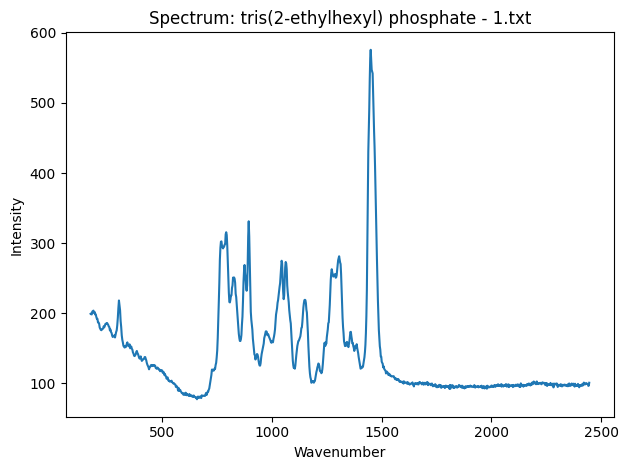

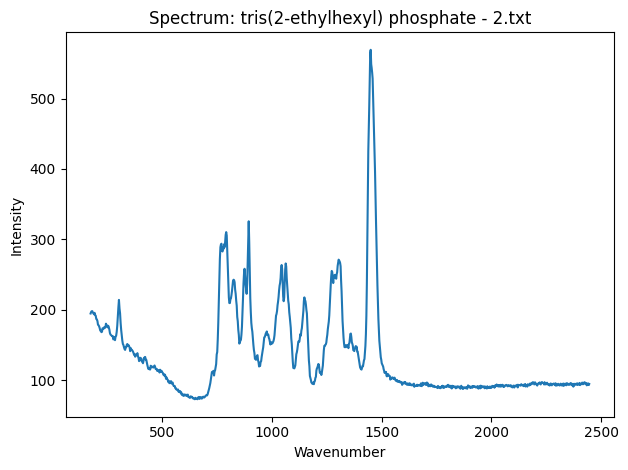

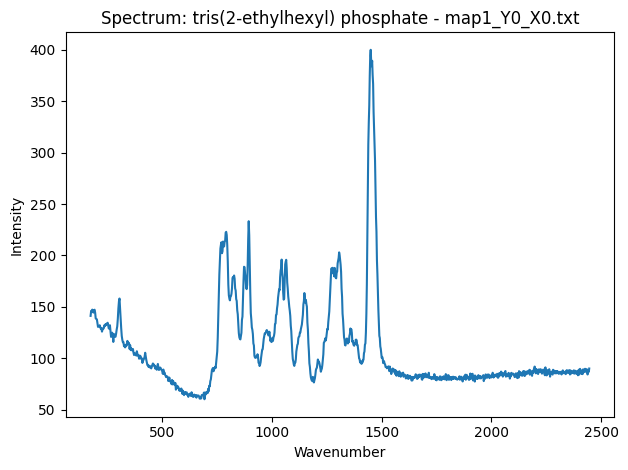

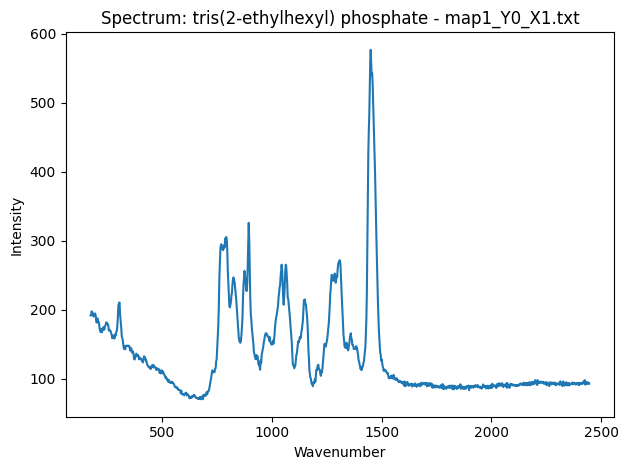

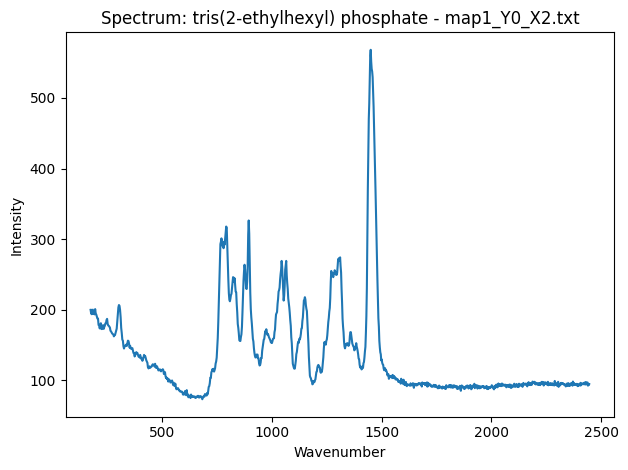

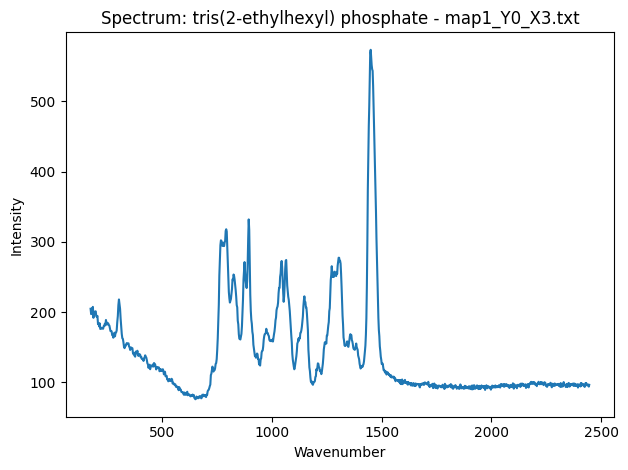

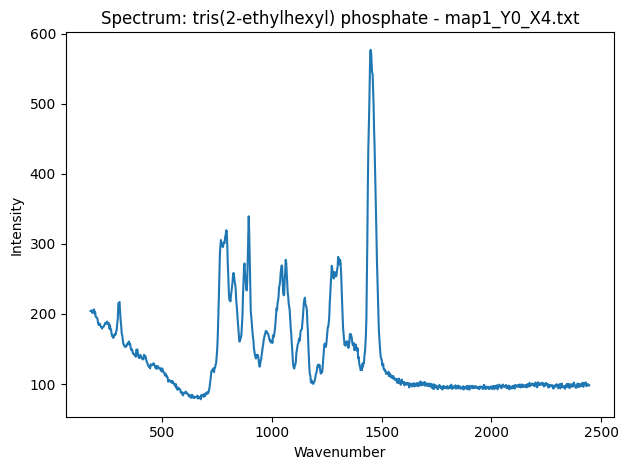

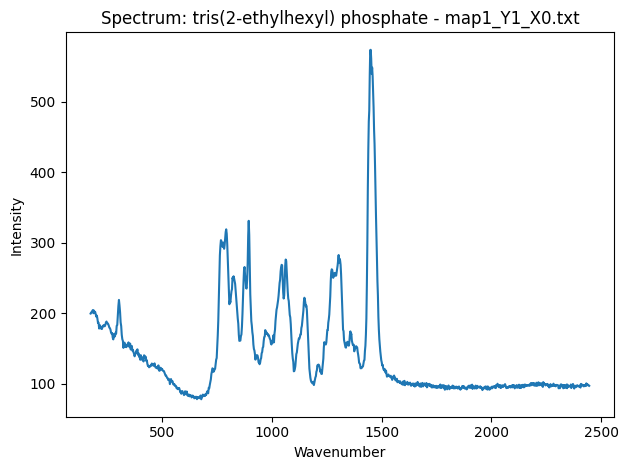

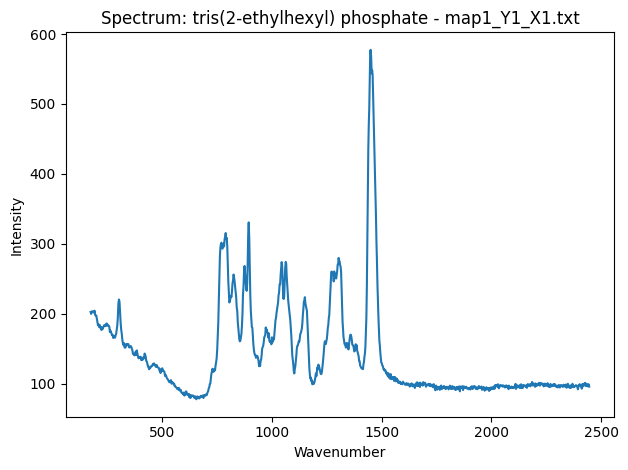

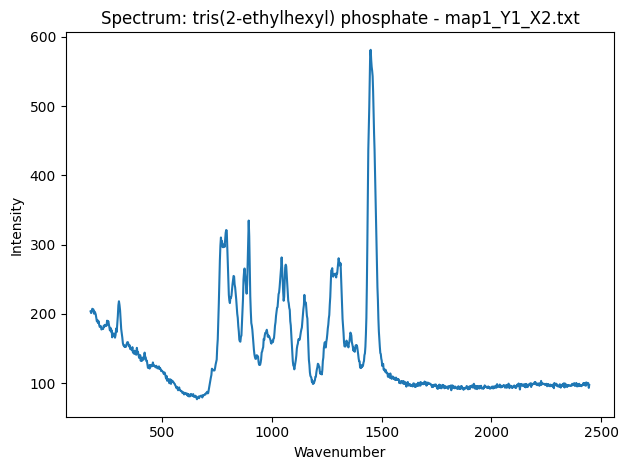

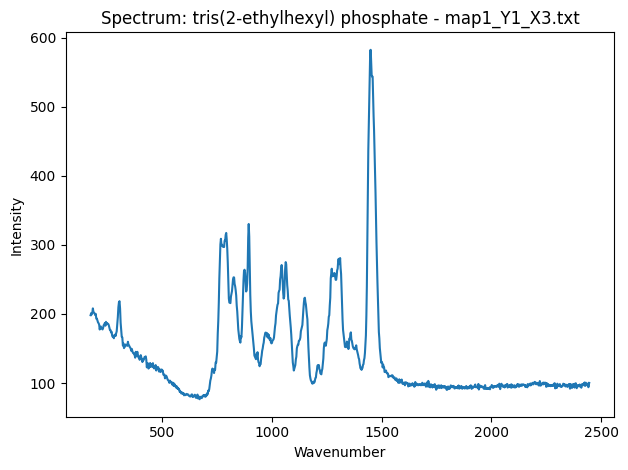

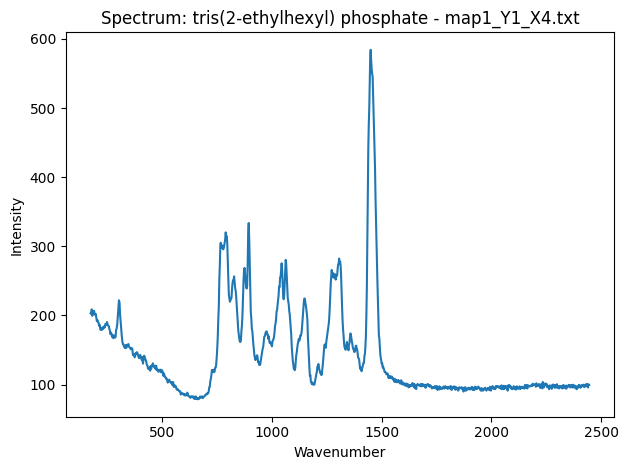

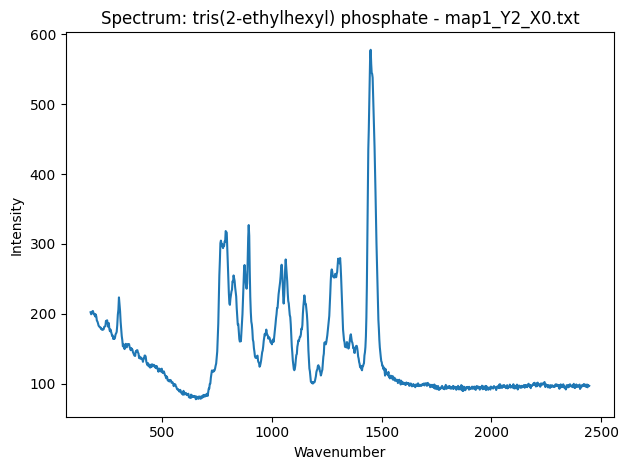

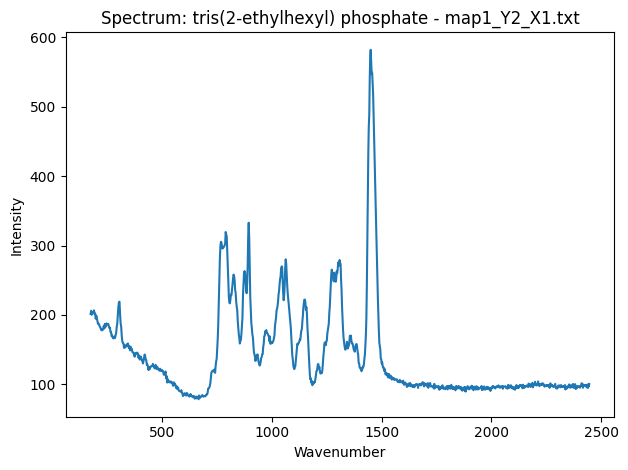

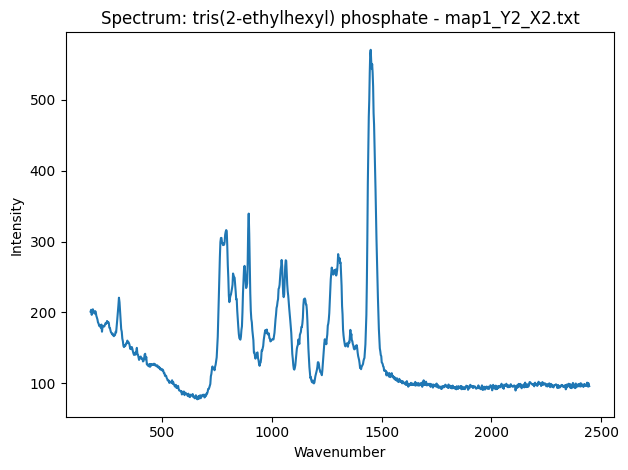

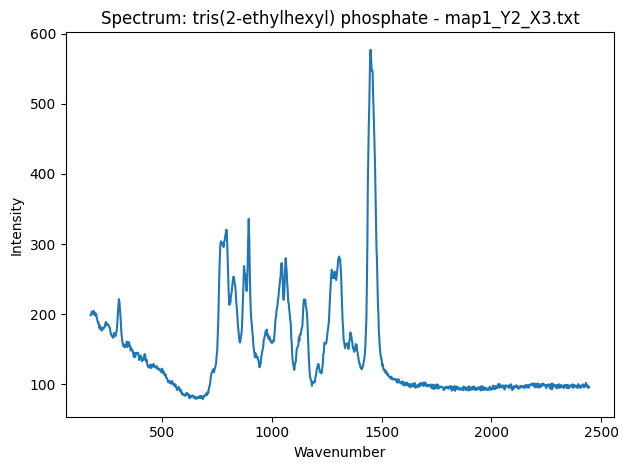

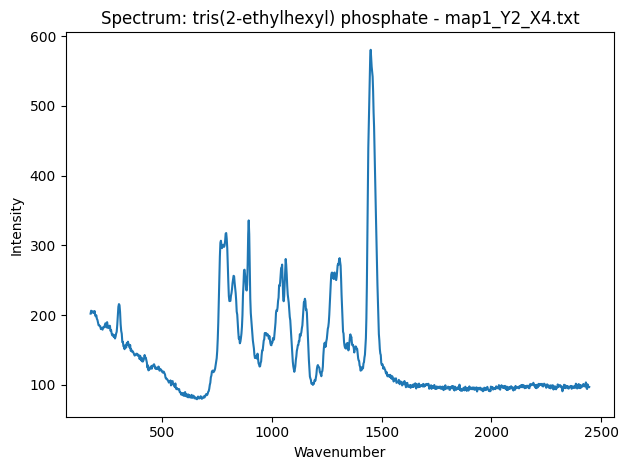

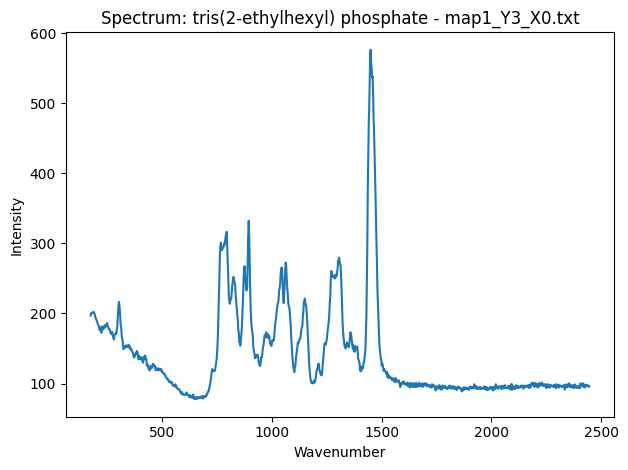

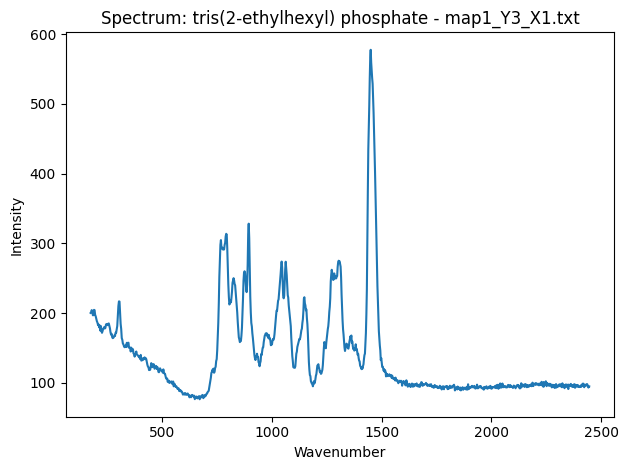

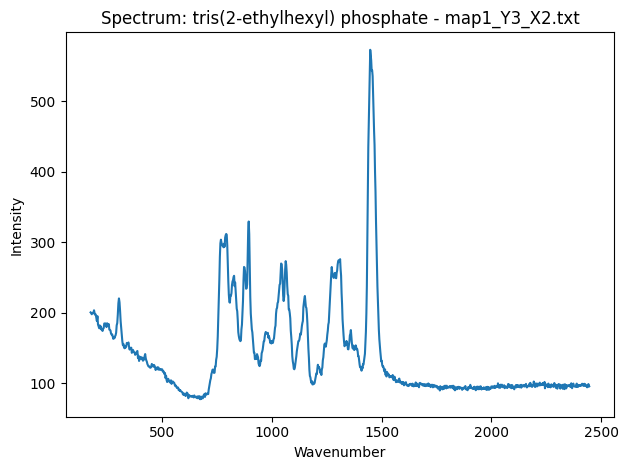

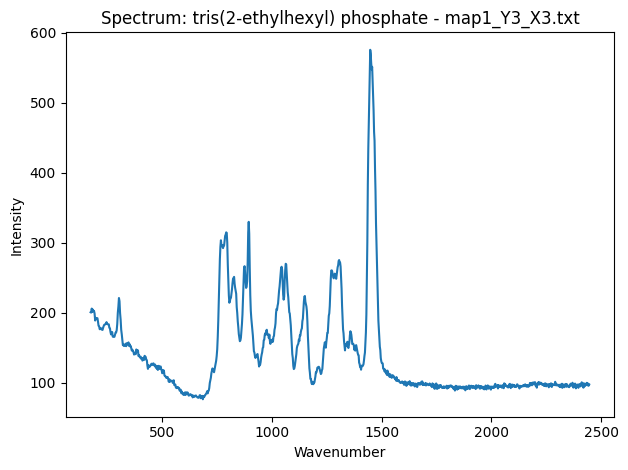

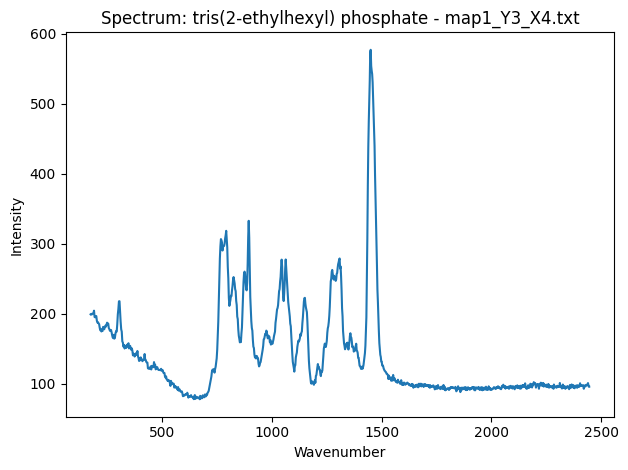

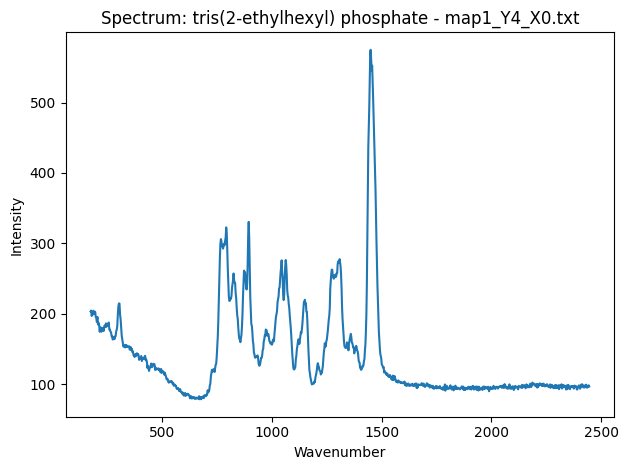

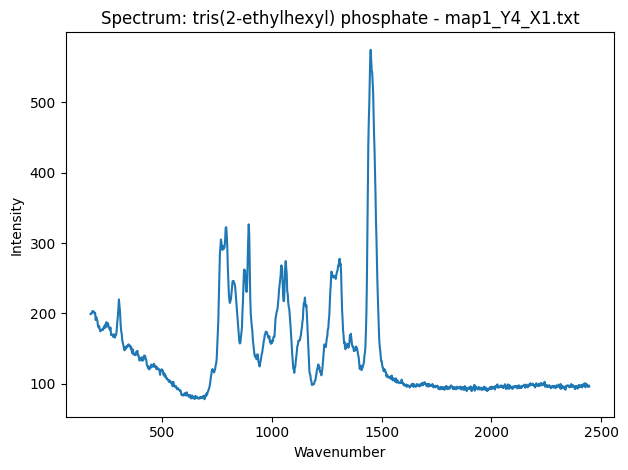

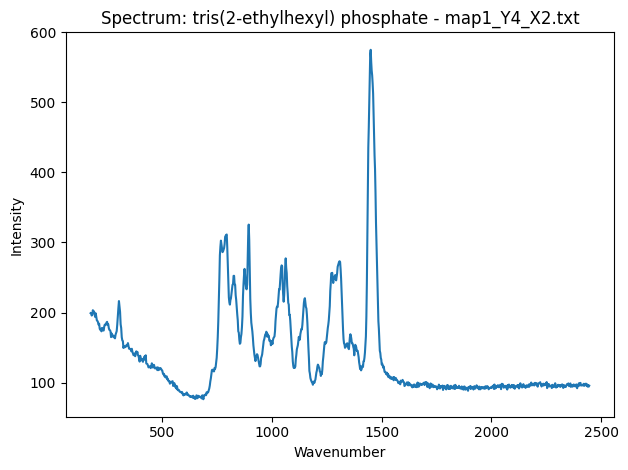

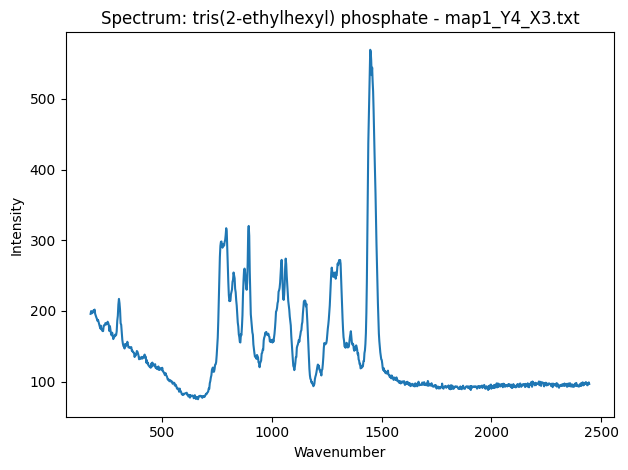

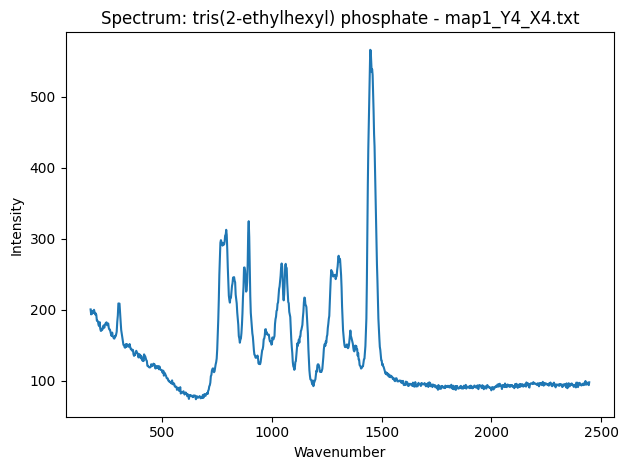

In [ ]:
def plot_spectra_in_folder(folder_path):
    """
    Iterates over all .txt files in the given folder and plots each spectrum.
    
    Parameters:
        folder_path (str): Path to the folder containing .txt spectra files.
    """
    # List all files in the directory
    for filename in os.listdir(folder_path):
        # Only process .txt files
        if filename.lower().endswith('.txt'):
            filepath = os.path.join(folder_path, filename)
            try:
                # Load two-column data: wavenumber and intensity
                data = np.loadtxt(filepath)
                wavenumbers = data[:, 0]
                intensity = data[:, 1]
                
                # Plot the spectrum
                plt.figure()
                plt.plot(wavenumbers, intensity)
                plt.title(f"Spectrum: {filename}")
                plt.xlabel("Wavenumber")
                plt.ylabel("Intensity")
                plt.tight_layout()
                plt.show()
                
            except Exception as e:
                print(f"Failed to plot {filename}: {e}")

if __name__ == "__main__":
    spectra_folder = "Jesse Dataset/tris(2-ethylhexyl) phosphate/txt"
    plot_spectra_in_folder(spectra_folder)

In [ ]:
import csv
def combine_spectra_to_rows(folder_path, output_csv_path):
    """
    Reads all .txt files in folder_path, then creates a CSV where:
      - Row 0: first column (wavenumbers) of the first file, plus filename (no .txt) as last entry
      - Row 1: second column (intensities) of the first file, plus filename
      - Rows 2..N: second column of each subsequent file, plus filename
    Saves the result to output_csv_path as a CSV.
    """
    # List and sort .txt files
    files = [f for f in os.listdir(folder_path) if f.lower().endswith('.txt')]
    files.sort()
    if not files:
        raise ValueError("No .txt files found in the folder.")

    rows = []

    # Process first file
    first_fname = files[0]
    name0 = os.path.splitext(first_fname)[0]
    data0 = np.loadtxt(os.path.join(folder_path, first_fname))
    rows.append(data0[:, 0].tolist() + [name0])  # row of wavenumbers + filename
    rows.append(data0[:, 1].tolist() + [name0])  # row of intensities + filename

    # Process remaining files (only intensities)
    for fname in files[1:]:
        name = os.path.splitext(fname)[0]
        data = np.loadtxt(os.path.join(folder_path, fname))
        rows.append(data[:, 1].tolist() + [name])

    # Write to CSV
    with open(output_csv_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for row in rows:
            writer.writerow(row)

    print(f"Combined CSV saved to {output_csv_path}")

if __name__ == "__main__":
    # Update these paths
    spectra_folder = "Jesse Dataset/_All_Reference_txt"
    output_file = "reference.csv"
    combine_spectra_to_rows(spectra_folder, output_file)

Combined CSV saved to reference.csv


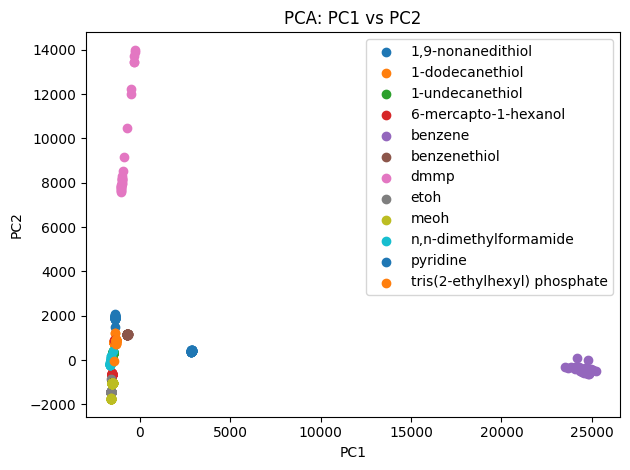

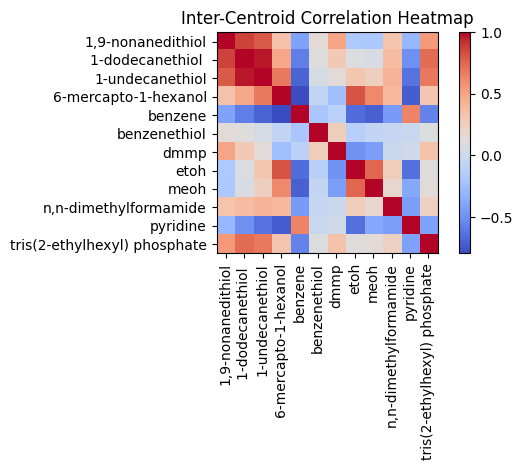

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load raw data
df = pd.read_csv("Jesse Dataset/reference.csv")
labels = df.iloc[:, -1]             # class labels
X = df.iloc[:, :-1].values          # raw numeric data

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X)

# Plot PCA scatter (first two PCs)
plt.figure()
unique_labels = labels.unique()
for lab in unique_labels:
    idx = labels == lab
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=str(lab))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA: PC1 vs PC2")
plt.legend()
plt.tight_layout()
plt.show()

# Compute centroids and correlation matrix
centroids = []
ordered_labels = sorted(unique_labels)
for lab in ordered_labels:
    idx = labels == lab
    centroids.append(X_pca[idx].mean(axis=0))
centroid_matrix = np.vstack(centroids)
corr_matrix = np.corrcoef(centroid_matrix)

# Plot correlation heatmap
plt.figure()
plt.imshow(corr_matrix, aspect='equal', interpolation='nearest',cmap='coolwarm')
plt.colorbar()
plt.xticks(range(len(ordered_labels)), ordered_labels, rotation=90)
plt.yticks(range(len(ordered_labels)), ordered_labels)
plt.title("Inter-Centroid Correlation Heatmap")
plt.tight_layout()
plt.show()


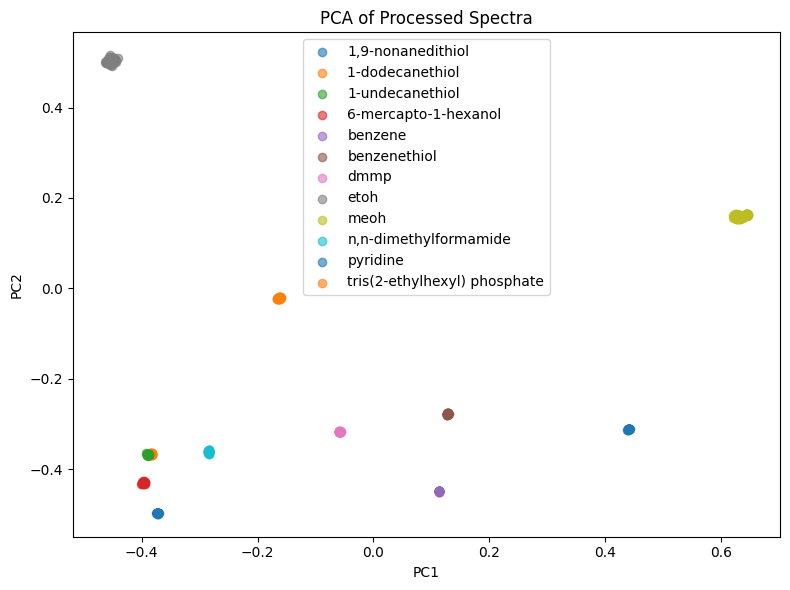

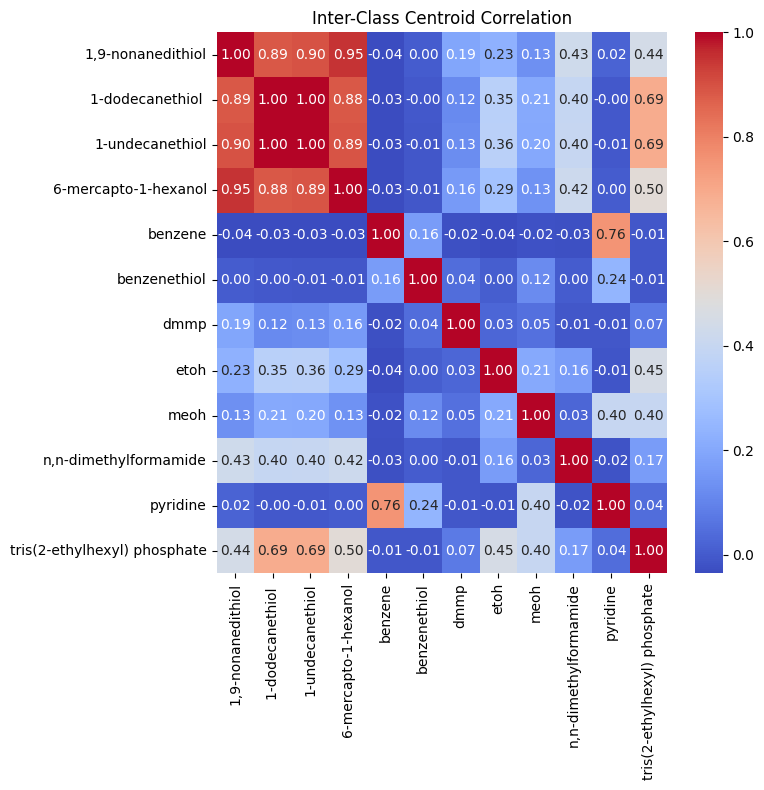

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Load full dataset
df = pd.read_csv('Jesse Dataset/reference.csv')

# Identify spectral columns and species
wavs_str = df.columns[:-1]
wavs = wavs_str.astype(float)

wcols = wavs_str

# Define preprocessing (baseline + l2 norm) from pipeline
def baseline_als(y, lam=1e4, p=0.01, niter=10):
    L = len(y)
    D = np.diff(np.eye(L), 2)
    D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        b = np.linalg.solve(np.diag(w) + D, w * y)
        w = p * (y > b) + (1 - p) * (y < b)
    return b

def preprocess(arr):
    out = np.zeros_like(arr)
    for i, spec in enumerate(arr):
        bkg = baseline_als(spec)
        corr = spec - bkg
        nrm = np.linalg.norm(corr)
        out[i] = corr / nrm if nrm else corr
    return out

# Apply preprocessing
spectra = df[wcols].values.astype(float)
species = df['Label'].values
proc = preprocess(spectra)

# PCA
pca = PCA(n_components=2)
Z = pca.fit_transform(proc)

# Plot PCA scatter
plt.figure(figsize=(8,6))
for sp in np.unique(species):
    mask_sp = species == sp
    plt.scatter(Z[mask_sp,0], Z[mask_sp,1], label=sp, alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Processed Spectra')
plt.legend()
plt.tight_layout()
plt.show()

# Compute class centroids
centroids = {}
for sp in np.unique(species):
    centroids[sp] = proc[species == sp].mean(axis=0)

# Build correlation matrix
corr_matrix = pd.DataFrame(index=centroids.keys(), columns=centroids.keys(), dtype=float)
for sp1 in centroids:
    for sp2 in centroids:
        corr = np.corrcoef(centroids[sp1], centroids[sp2])[0,1]
        corr_matrix.loc[sp1, sp2] = corr

# Display correlation heatmap
plt.figure(figsize=(8,8))
sns.heatmap(corr_matrix.astype(float), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Inter-Class Centroid Correlation')
plt.tight_layout()
plt.show()


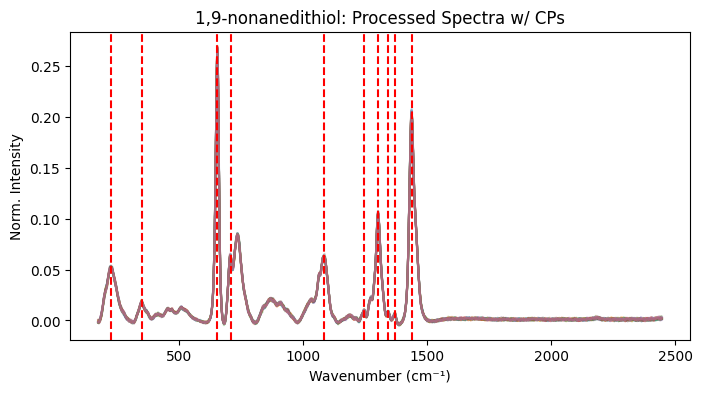

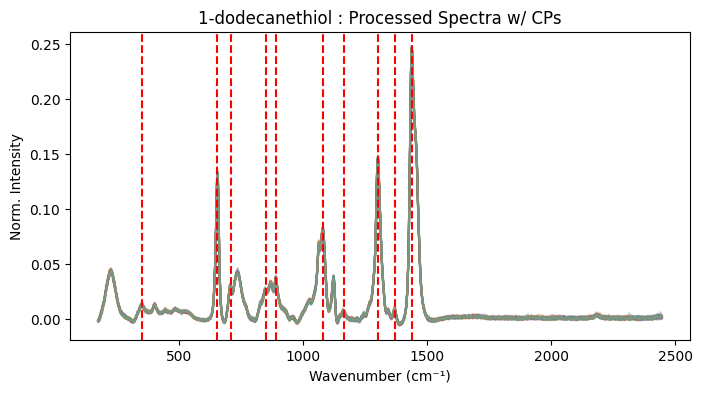

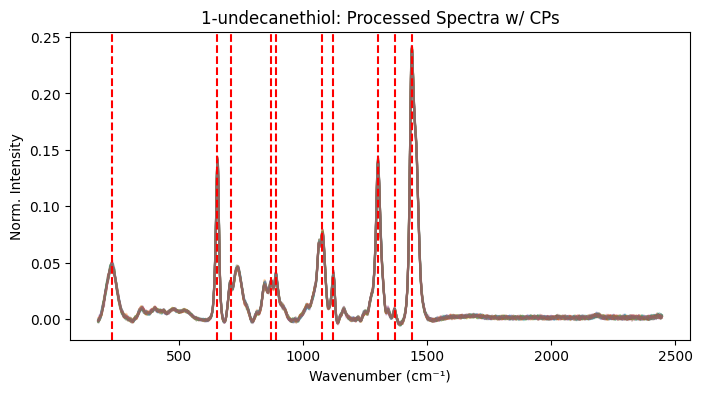

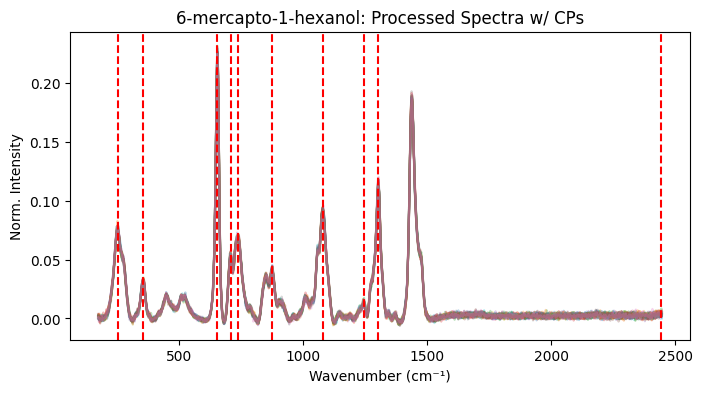

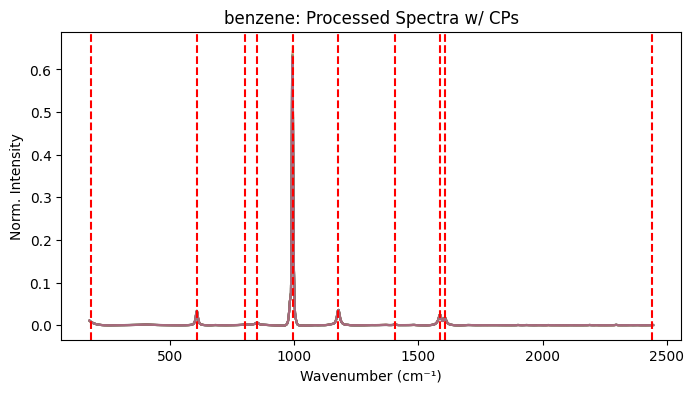

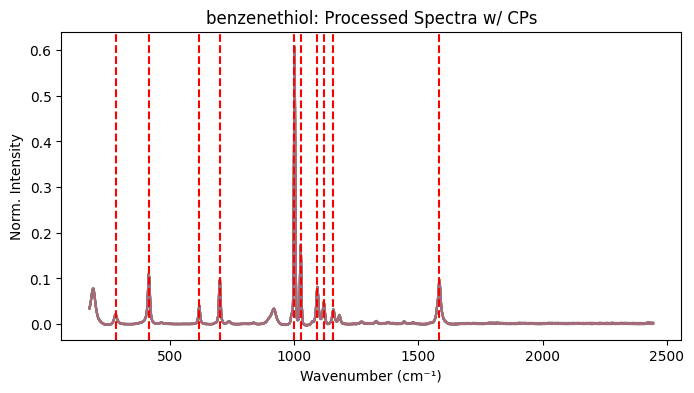

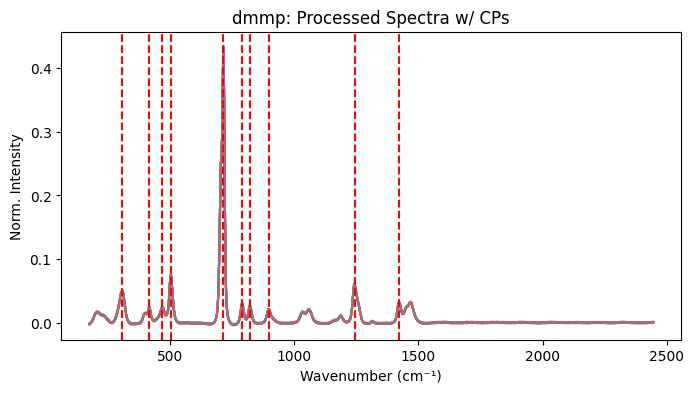

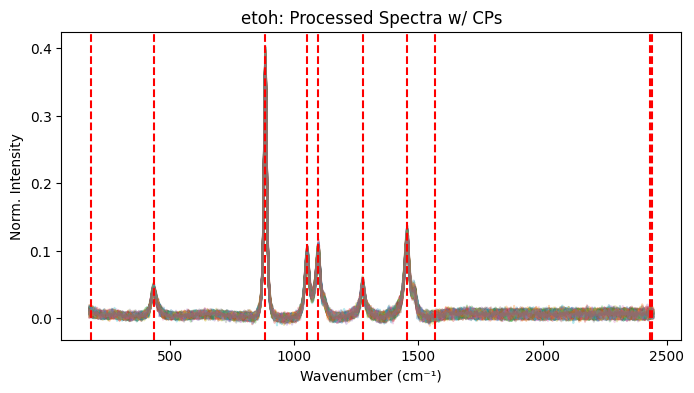

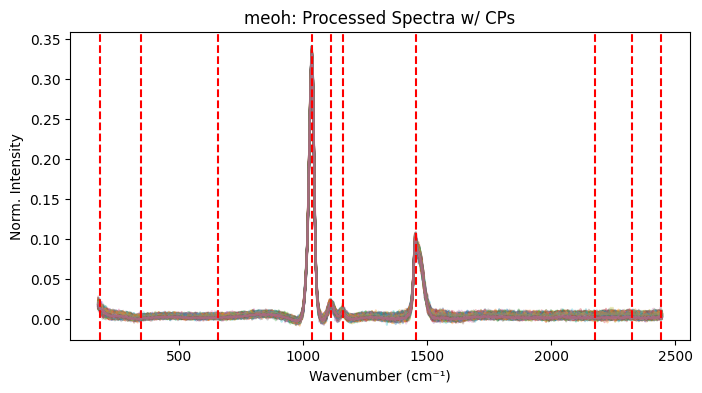

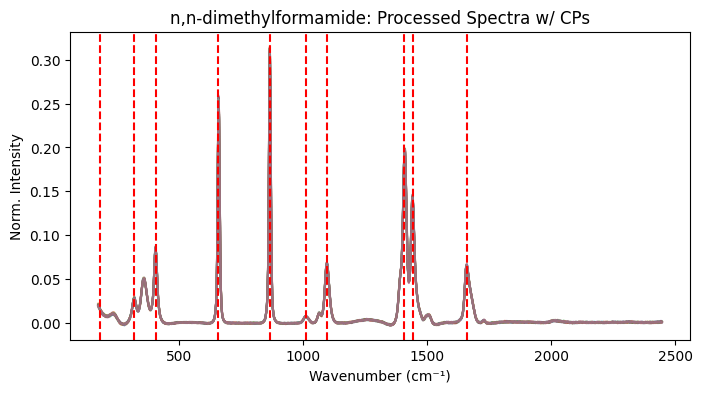

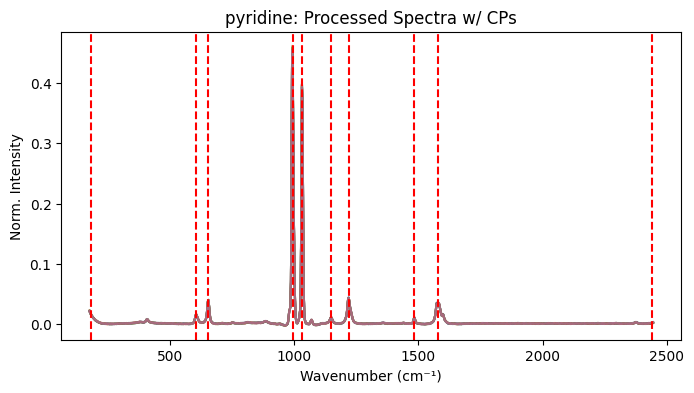

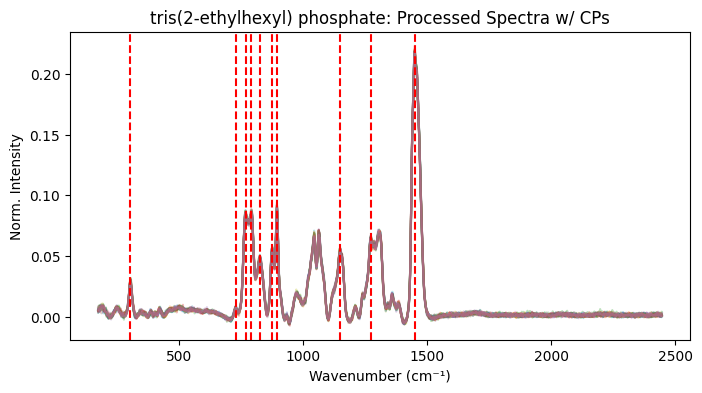

In [63]:
import pandas as pd
import numpy as np

# 1) Load raw data
raw_ref   = pd.read_csv('Jesse_Dataset/reference.csv')
wavs_all  = raw_ref.columns[:-1].astype(float)


# 2) Subset your wavenumbers and raw arrays
wavs       = wavs_all
wavs_str   = raw_ref.columns[:-1]
refs_raw   = raw_ref[wavs_str].values.astype(float)

# 3) Preprocess (baseline + ℓ₂ norm) on cropped data
def baseline_als(y, lam=1e4, p=0.01, niter=10):
    L = len(y)
    D = np.diff(np.eye(L), 2); D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        W = np.diag(w); Z = W + D
        b = np.linalg.solve(Z, w * y)
        w = p * (y > b) + (1-p) * (y < b)
    return b

def preprocess(spectra):
    out = np.zeros_like(spectra)
    for i, spec in enumerate(spectra):
        bkg  = baseline_als(spec)
        corr = spec - bkg
        nrm  = np.linalg.norm(corr)
        out[i] = corr / nrm if nrm else corr
    return out

refs_proc = preprocess(refs_raw)


# 4) Run CaPE and plotting on refs_proc using only wavs and wavs_str
K_smooth, N_peak = 5, 10

def smooth_spectrum(spec):
    return np.convolve(spec, np.ones(K_smooth)/K_smooth, mode='same')

def CaPE(refs):
    sm = np.array([smooth_spectrum(s) for s in refs])
    counts = np.zeros(sm.shape[1], int)
    for s in sm:
        pks, _ = find_peaks(s)  # Adjust height threshold as needed
        counts[pks] += 1
    return sorted(np.argsort(counts)[-N_peak:])

import matplotlib.pyplot as plt

for chem in sorted(raw_ref['Label'].unique()):
    idxs  = raw_ref.index[raw_ref['Label']==chem]
    refs_p = refs_proc[idxs]
    
    cp_idxs = CaPE(refs_p)
    cp_wavenums = wavs[cp_idxs]

    
    # Overlay spectra
    plt.figure(figsize=(8,4))
    for spec in refs_p:
        plt.plot(wavs, spec, alpha=0.3)
    for w in cp_wavenums:
        plt.axvline(w, linestyle='--', color='red')
    plt.title(f"{chem}: Processed Spectra w/ CPs")
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Norm. Intensity')
    plt.show()

In [58]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# 1. Load data
ref_df = pd.read_csv('Jesse Dataset/reference.csv')
query_df = pd.read_csv('Jesse Dataset/query.csv')

if 'Label' not in ref_df.columns and 'Species' in ref_df.columns:
    ref_df.rename(columns={'Species':'Label'}, inplace=True)
if 'Label' not in query_df.columns and 'Species' in query_df.columns:
    query_df.rename(columns={'Species':'Label'}, inplace=True)

def identify_spectrum_pipeline(query_df, ref_df,
    crop_max=2500, lam=1e4, p=0.01, niter=10,
    K_smooth=3, N_peak=15, w_max=36,
    height=0.02, prominence=0.02):

    # --- prepare data matrices ---
    wav_cols = query_df.columns[:-1]
    wavs_num = pd.to_numeric(wav_cols)
    keep     = wav_cols[wavs_num < crop_max]
    Q_raw = query_df[keep].values.astype(float)
    R_raw = ref_df  [keep].values.astype(float)
    labels = ref_df['Label'].values
    classes = np.unique(labels)
    n_classes = len(classes)

    # --- baseline & normalize ---
    def baseline_als(y):
        L = len(y)
        D = np.diff(np.eye(L), 2); D = lam * D.dot(D.T)
        w = np.ones(L)
        for _ in range(niter):
            b = np.linalg.solve(np.diag(w)+D, w*y)
            w = p*(y>b) + (1-p)*(y<b)
        return b

    def preprocess(arr):
        out = np.zeros_like(arr)
        for i,s in enumerate(arr):
            b = baseline_als(s)
            c = s - b
            out[i] = c/np.linalg.norm(c) if np.linalg.norm(c)>0 else c
        return out

    Q = preprocess(Q_raw)
    R = preprocess(R_raw)

    # --- smooth helper ---
    def smooth(x):
        return np.convolve(x, np.ones(K_smooth)/K_smooth, mode='same')

    # --- 1) build raw peak counts per class ---
    counts_by_class = {chem: np.zeros(Q.shape[1], int)
                       for chem in classes}
    for chem in classes:
        specs = R[labels==chem]
        cnt  = counts_by_class[chem]
        for s in specs:
            pks, _ = find_peaks(smooth(s), height=height, prominence=prominence)
            cnt[pks] += 1

    # --- 2) compute document frequency and idf ---
    df = np.zeros(Q.shape[1], int)
    for i in range(Q.shape[1]):
        # count number of classes where this index ever lit up
        df[i] = sum(1 for chem in classes if counts_by_class[chem][i] > 0)
    idf = np.log(n_classes / (1 + df))

    # --- 3) pick TF–IDF peaks & build reference comps ---
    CPs, Ref_comp = {}, {}
    for chem in classes:
        tf = counts_by_class[chem].astype(float)
        tfidf = tf * idf                   # elementwise TF–IDF score
        idxs = np.argsort(tfidf)[-N_peak:] # top N_peak TF–IDF indices
        CPs[chem] = sorted(idxs)

        # now extract intensity vectors at these CPs
        comp = []
        for s in R[labels==chem]:
            vec = [ np.max(s[max(0,i-w_max//2):i+w_max//2+1])
                    for i in CPs[chem] ]
            comp.append(minmax_scale(vec))
        Ref_comp[chem] = np.vstack(comp)

    # --- 4) identification by mean dot product ---
    rankings = []
    for s in Q:
        scores = {}
        for chem in classes:
            vec = [ np.max(s[max(0,i-w_max//2):i+w_max//2+1])
                    for i in CPs[chem] ]
            qv  = minmax_scale(vec)
            scores[chem] = (Ref_comp[chem] @ qv).mean()
        rankings.append(sorted(scores, key=scores.get, reverse=True))

    return rankings, Q, CPs, Ref_comp

# ---- run and evaluate -----
rankings, Q, CPs, Ref_comp = identify_spectrum_pipeline(query_df, ref_df)

true = query_df['Label'].values
pred1 = [r[0] for r in rankings]
pred2 = [r[1] for r in rankings]

print("Top-1 Acc:", accuracy_score(true, pred1))
print("Top-2 Acc:", np.mean([t in (p1,p2) for t,p1,p2 in zip(true,pred1,pred2)]))

# (plot confusion matrix etc. as before)


Top-1 Acc: 0.16666666666666666
Top-2 Acc: 0.3333333333333333


Top-1 PCA Acc: 1.0
Top-2 PCA Acc: 1.0


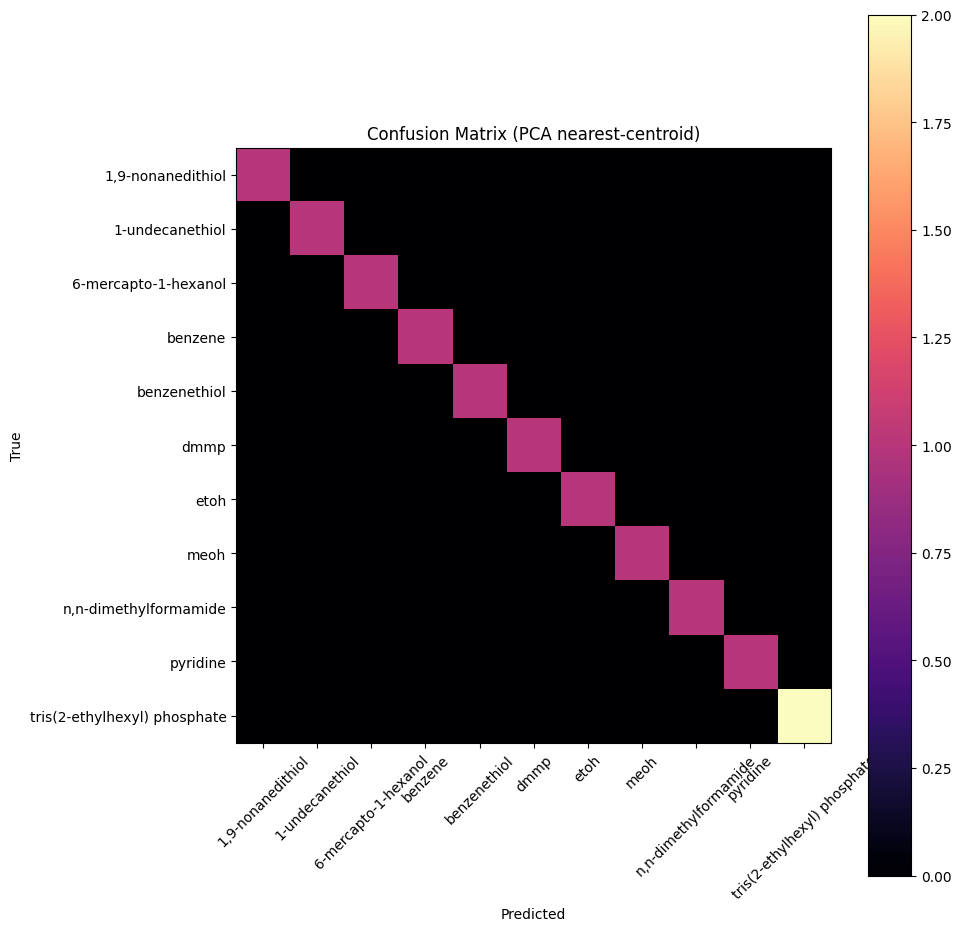

In [61]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Load data
ref_df   = pd.read_csv('Jesse Dataset/reference.csv')
query_df = pd.read_csv('Jesse Dataset/query.csv')
if 'Label' not in ref_df.columns and 'Species' in ref_df.columns:
    ref_df.rename(columns={'Species':'Label'}, inplace=True)
if 'Label' not in query_df.columns and 'Species' in query_df.columns:
    query_df.rename(columns={'Species':'Label'}, inplace=True)

def identify_with_pca(query_df, ref_df,
                     crop_max=2500, lam=1e4, p=0.01, niter=10,
                     n_pca=10):
    # --- prepare matrices ---
    wavs      = pd.to_numeric(query_df.columns[:-1])
    keep_idxs = np.where(wavs < crop_max)[0]
    Q_raw     = query_df.iloc[:, keep_idxs].values
    R_raw     = ref_df  .iloc[:, keep_idxs].values
    labels    = ref_df['Label'].values
    classes   = np.unique(labels)
    
    # --- baseline & ℓ2-normalize ---
    def baseline_als(y):
        L = len(y)
        D = np.diff(np.eye(L), 2); D = lam * D.dot(D.T)
        w = np.ones(L)
        for _ in range(niter):
            b = np.linalg.solve(np.diag(w)+D, w*y)
            w = p*(y>b) + (1-p)*(y<b)
        return b

    def preprocess(arr):
        out = np.zeros_like(arr)
        for i,s in enumerate(arr):
            b = baseline_als(s)
            c = s - b
            out[i] = c/np.linalg.norm(c) if np.linalg.norm(c)>0 else c
        return out

    Q = preprocess(Q_raw)
    R = preprocess(R_raw)

    # --- PCA on reference spectra ---
    pca      = PCA(n_components=n_pca)
    R_pca    = pca.fit_transform(R)
    Q_pca    = pca.transform(Q)
    
    # --- compute class centroids in PCA space ---
    centroids = {
        chem: R_pca[labels==chem].mean(axis=0)
        for chem in classes
    }

    # --- classify by nearest‐centroid in PCA space ---
    rankings = []
    for qv in Q_pca:
        # compute distance to each centroid
        dists = {chem: np.linalg.norm(qv - centroids[chem])
                 for chem in classes}
        # sort by ascending distance → lowest = best match
        ranking = sorted(dists, key=dists.get)
        rankings.append(ranking)

    return rankings, Q_pca, R_pca, centroids

# ---- run & evaluate ----
rankings, Q_pca, R_pca, centroids = identify_with_pca(query_df, ref_df)

true  = query_df['Label'].values
pred1 = [r[0] for r in rankings]
pred2 = [r[1] for r in rankings]

print("Top-1 PCA Acc:", accuracy_score(true, pred1))
print("Top-2 PCA Acc:", np.mean([t in (p1,p2) for t,p1,p2 in zip(true,pred1,pred2)]))

# Confusion matrix
labels_unique = np.unique(true)
cm = confusion_matrix(true, pred1, labels=labels_unique)
plt.figure(figsize=(10,10))
plt.imshow(cm, cmap='magma', interpolation='nearest')
plt.xticks(range(len(labels_unique)), labels_unique, rotation=45)
plt.yticks(range(len(labels_unique)), labels_unique)
plt.colorbar()
plt.title("Confusion Matrix (PCA nearest‐centroid)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
